# How to read/Write Data from Blob Storage

Since the jars required to create a connection to azure blob storage are not included with the spark instalation, they need to be installed separately
in order to do so the following commands need to be ran
 - !wget https://repo1.maven.org/maven2/com/microsoft/azure/azure-storage/8.6.6/azure-storage-8.6.6.jar -O /opt/spark/jars/azure-storage-8.6.6.jar
 - !wget https://repo1.maven.org/maven2/com/azure/azure-storage-blob/12.10.0/azure-storage-blob-12.10.0.jar -O /opt/spark/jars/azure-storage-blob-12.10.0.jar
 - !wget https://repo1.maven.org/maven2/org/apache/hadoop/hadoop-azure/3.3.4/hadoop-azure-3.3.4.jar -O /opt/spark/jars/hadoop-azure-3.3.4.jar
 - !wget https://repo1.maven.org/maven2/org/eclipse/jetty/jetty-util/9.4.45.v20220203/jetty-util-9.4.45.v20220203.jar -O /opt/spark/jars/jetty-util-9.4.45.jar 
 - !wget https://repo1.maven.org/maven2/org/eclipse/jetty/jetty-util-ajax/9.4.45.v20220203/jetty-util-ajax-9.4.45.v20220203.jar -O /opt/spark/jars/jetty-util-ajax-9.4.45.jar
  - !wget https://repo1.maven.org/maven2/org/eclipse/jetty/jetty-server/9.4.45.v20220203/jetty-server-9.4.45.v20220203.jar -O /opt/spark/jars/jetty-server-9.4.45.jar
  
These Jars need to be installed in this folder : /opt/spark/jars/jetty-server-9.4.45.jar
pip install pandas==1.2.0
This is taking place because of the spark installation (spark-3.5.1-bin-hadoop3.tgz) - -  unable to load native-hadoop library for your platform... using builtin-java classes where applicable

In [1]:
#!pip install pandas==1.2.0
#!pip install seaborn

In [2]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.window import Window
from pyspark.sql.types import *
from pyspark.sql.functions import *
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 500)
n_1 = datetime.datetime.now()

In [3]:
# Create a SparkSession
spark = SparkSession.builder \
    .appName("test_") \
    .master("spark://42c600268bb1:7077") \
    .getOrCreate()
# Define the storage account name and container name
storage_account_name = "projectsstoragealejo"
container_name = "projects-spark"
access_key = "Ptoy4is6+VXkh91yufbxyHJPNS9nx8QIJ8zQrNKsVA8oDklZDxfqn4jiFmMFhEefB+HssdBcGd1Z+AStQVobgQ=="
# Define the Azure Blob Storage URL
azure_blob_url = f"wasbs://{container_name}@{storage_account_name}.blob.core.windows.net/"
# Provide your Azure Storage account access key
spark.conf.set(f"fs.azure.account.key.{storage_account_name}.blob.core.windows.net", access_key)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/06 19:54:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/usr/local/lib/python3.7/dist-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


num_rows = 1000
df = spark.range(num_rows) \
    .withColumn("Temperature", (rand() * 50 + 50)) \
    .withColumn("Humidity", (rand() * 50 + 50)) \
    .withColumn("Pressure", (rand() * 100 + 900)) \
    .withColumn("Wind_Speed", (rand() * 20)) \
    .withColumn("Cloud_Cover", (rand() * 100)) \
    .withColumn("Weight", (expr("CASE WHEN Temperature > 70 THEN 5 " +
                                 "WHEN Humidity < 30 THEN 4 " +
                                 "WHEN Pressure < 950 THEN 3 " +
                                 "WHEN Wind_Speed > 15 THEN 2 " +
                                 "ELSE 1 END").cast(IntegerType()))) \
    .withColumn("Target", (expr("CASE WHEN Cloud_Cover < 20 THEN 'Sunny' " +
                                "WHEN Cloud_Cover < 70 THEN 'Partly Cloudy' " +
                                "ELSE 'Cloudy' END")))

def generate_timestamp(index):
    start_timestamp = datetime.datetime(2024, 3, 5, 0, 0, 0)
    return start_timestamp - datetime.timedelta(minutes=index*5)

spark.udf.register("generate_timestamp", generate_timestamp, TimestampType())
df = df.withColumn("timestamp", expr("generate_timestamp(id)"))
#df.write.parquet(azure_blob_url+"weather_data.parquet")

In [4]:
df = spark.read.parquet(azure_blob_url+"weather_data.parquet")

24/03/06 19:54:25 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-azure-file-system.properties,hadoop-metrics2.properties


In [5]:
df.printSchema()

root
 |-- id: long (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Humidity: double (nullable = true)
 |-- Pressure: double (nullable = true)
 |-- Wind_Speed: double (nullable = true)
 |-- Cloud_Cover: double (nullable = true)
 |-- Weight: integer (nullable = true)
 |-- Target: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)



In [6]:
# Add Month, Year , Day to table

df = df.withColumn("Year",year(col("timestamp"))) \
    .withColumn("Month",month(col("timestamp"))) \
    .withColumn("Day",dayofmonth(col("timestamp"))) \
    .withColumn("month-year", concat(month(col("timestamp")), lit(" - "), year(col("timestamp"))))
#df.show(3)

# Get Previous Temperature for every month in every yerar and Compare
window_spec_1 = Window.partitionBy("month-year").orderBy("timestamp")
df_temp_w = df.withColumn("Prev_Temperature", lag("Temperature").over(window_spec_1)) \
    .withColumn("Temp_Diff",col("Temperature") - col("Prev_Temperature")) \
    .select("Temperature","Prev_Temperature","Temp_Diff","timestamp","month-year")
#df_temp_w.show()
_chk_1 = df_temp_w.filter(
    col("month-year") == "11 - 1995").toPandas()

#Change in Temperature Aggregation
agg_temp = df_temp_w.groupBy(
        "month-year").agg(
            count("Temp_Diff").alias("Count"),
            avg("Temp_Diff").alias("Mean"),
            median("Temp_Diff").alias("median"),
            stddev("Temp_Diff").alias("stdv")
    )


agg_temp_pdf = agg_temp.withColumn("mth",split(col("month-year"),"-").getItem(0)) \
    .withColumn("yr",split(col("month-year"),"-").getItem(1)) \
    .toPandas()
#agg_temp.write.csv(azure_blob_url+"agg_temp_data.csv",header=True)
agg_temp.show(10)


24/03/06 19:57:13 ERROR TaskSchedulerImpl: Lost executor 2 on 172.20.0.7: Command exited with code 137
24/03/06 19:57:14 ERROR TransportRequestHandler: Error sending result RpcResponse[requestId=9186862992881712753,body=NioManagedBuffer[buf=java.nio.HeapByteBuffer[pos=0 lim=81 cap=156]]] to /172.20.0.7:41380; closing connection
io.netty.channel.StacklessClosedChannelException
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source)
24/03/06 19:57:14 WARN TaskSetManager: Lost task 1.0 in stage 6.0 (TID 11) (172.20.0.7 executor 2): ExecutorLostFailure (executor 2 exited caused by one of the running tasks) Reason: Command exited with code 137
24/03/06 19:57:49 WARN TaskSetManager: Lost task 1.1 in stage 6.0 (TID 14) (172.20.0.7 executor 4): FetchFailed(null, shuffleId=1, mapIndex=-1, mapId=-1, reduceId=53, message=
org.apache.spark.shuffle.MetadataFetchFailedException: Missing an output location for shuffle 1 partition 53
	at org.apache.spark.MapOu

+----------+-----+--------------------+--------------------+------------------+
|month-year|Count|                Mean|              median|              stdv|
+----------+-----+--------------------+--------------------+------------------+
|  1 - 1935| 8927|0.002168256223790024| 0.18807056596119764|  20.3523596592974|
|  1 - 1943| 8927|-8.76104042829612...|0.023595834648872938|20.488594394226823|
|  1 - 1946| 8927|6.744527105601714E-4|-0.19048256216544246|20.262662517025266|
|  1 - 1951| 8927|-0.00268879092508...| -0.3657152994107946|20.175674016787937|
|  1 - 1953| 8927|-8.83137132356547...|  -0.108197697186867|20.241836230329916|
|  1 - 1955| 8927|-3.64142841308176...|0.040190133207829604|20.371177402389346|
|  1 - 1960| 8927|-0.00421994429753...|-0.15176855323625205|20.337131071404187|
|  1 - 1961| 8927|-0.00233066421373...|-0.00937489663090...|20.545401736796126|
|  1 - 1974| 8927| -0.0024877919902101|-0.04392825026520342| 20.18358002339696|
|  1 - 1979| 8927|-0.00100976116572...|-

In [8]:
spark.stop()

0:08:28.961101


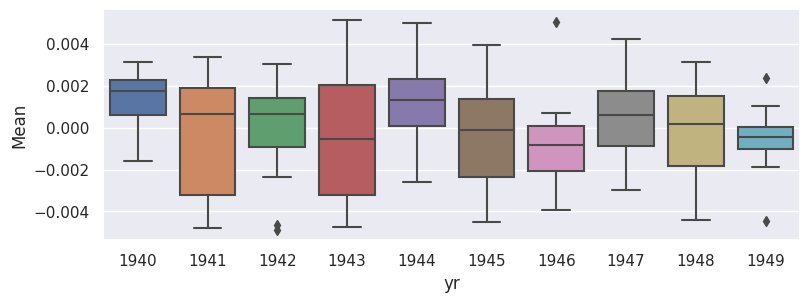

In [7]:
agg_temp_pdf["mth"] = pd.to_numeric(agg_temp_pdf["mth"])
agg_temp_pdf["yr"] = pd.to_numeric(agg_temp_pdf["yr"])
agg_temp_pdf = agg_temp_pdf.sort_values(["yr","mth"], ascending = [True,True])
agg_temp_pdf["dt"] = agg_temp_pdf["mth"].astype(str) + "-" +agg_temp_pdf["yr"].astype(str)
agg_temp_pdf["dt"] = agg_temp_pdf["dt"].apply(lambda x: datetime.datetime(month=int(x.split("-")[0]), 
                                                                         year=int(x.split("-")[1]), 
                                                                         day=1))
#agg_temp_pdf["dt"] = agg_temp_pdf["dt"].apply(lambda x: [int(x.split("-")[0]), int(x.split("-")[1]), 1])
sns.set_theme(rc={'figure.figsize':(9,3)})
bar = sns.lineplot(
    data = agg_temp_pdf[
        (agg_temp_pdf["dt"] < datetime.datetime(1950,1,1)) &
        (agg_temp_pdf["dt"] >= datetime.datetime(1940,1,1))
    ],
    x = "dt",
    y = "Mean"
)
plt.xticks(rotation = 70)
plt.savefig("line_plot.png")
plt.clf()
box = sns.boxplot(
    data = agg_temp_pdf[
        (agg_temp_pdf["dt"] < datetime.datetime(1950,1,1)) &
        (agg_temp_pdf["dt"] >= datetime.datetime(1940,1,1))
    ],
    y = "Mean",
    x = "yr"

)
plt.savefig("boxplot.png")

n_2 = datetime.datetime.now()
print(n_2-n_1)
